Niall Carbery 22380966

### 
<b>How long does it take for an isolated system to undergo relaxation when starting in the excited state?</b>

The $T_1$ time characterises the time it takes for an excited state to deacy to its ground state. Where $T_1 = \frac 1 {\gamma}$ In this case we use  $\gamma = \frac 1 {111}$ ns. So our $T_1$ time is $1.11*10^{-7}$ seconds

### 
<b>How should we modify the Hamiltonian to observe Rabi oscillations in an isolated system? What
influences the frequency of Rabi oscillations of the isolated system? </b>

To drive transitions between |0> and |1> states, a time-varying magnetic field component is applied along another axis. The Hamilitonian must have off the-diagonal terms that allow for oscialltions in time of the probability amplitude assocaited with |0> and |1> 

We must apply this magnetic field component along the X axis to observe Rabi osciallations. The magnetic field $B_x(t)$ at exactly $w_z$ wehre $w_z = \frac {g\mu_B
 B_z}{\hbar}$ The Rabi frequency influences the frequency at ehich the rabi oscilations occur with the rabi frequency, $\omega_{rabi} = \sqrt{(\omega-\omega_0)^2+4(\frac{g\mu_Bb}{2\hbar})^2}$

###
<b>How would you describe the qubit’s dynamics in an open quantum system allowing for energy loss from
the system to the environment? Discuss this quantitatively using simulations with the suggested value
of the decay rate γ? How do the dynamics change if the decay rate is varied to 2 ∗γ and 0.2∗γ? Ensure
you discuss the effect on the diagonal and off-diagonal elements of the density matrix. </b>

For a qubit in equal superposition of |0> and |1>, there is an exponential decay into the ground state in such that the populations of the denisty matrix $p_{00}$ and $p_{11}$:

$p_{11} = exp(-\gamma t)$

$p_{00} = 1 - exp(-\gamma t)$

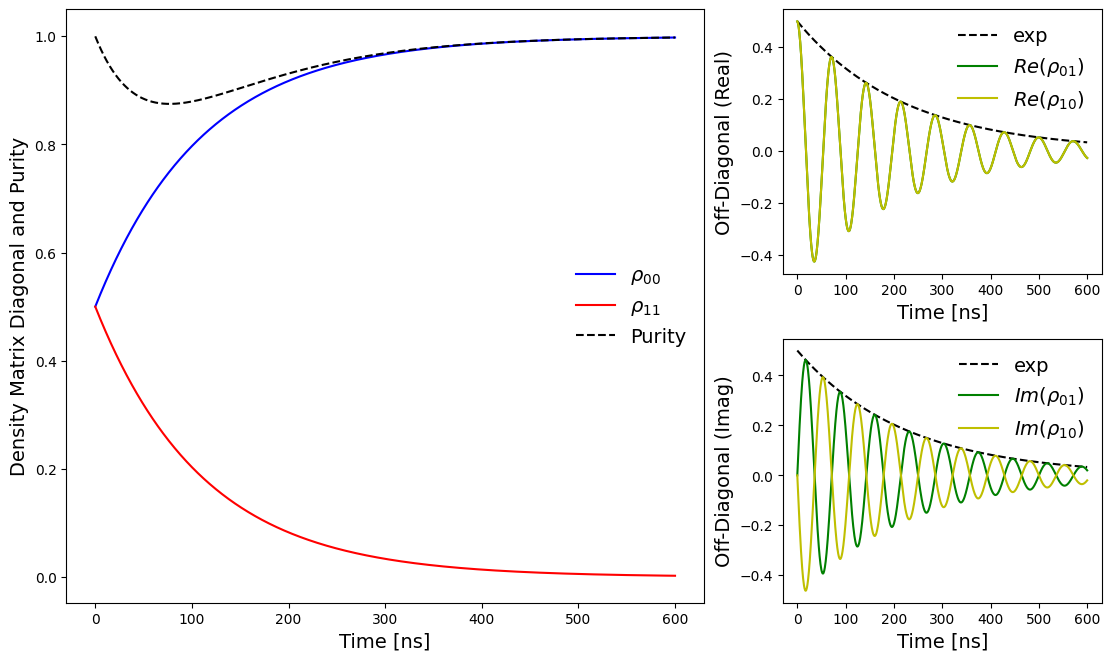

At $2*\gamma$

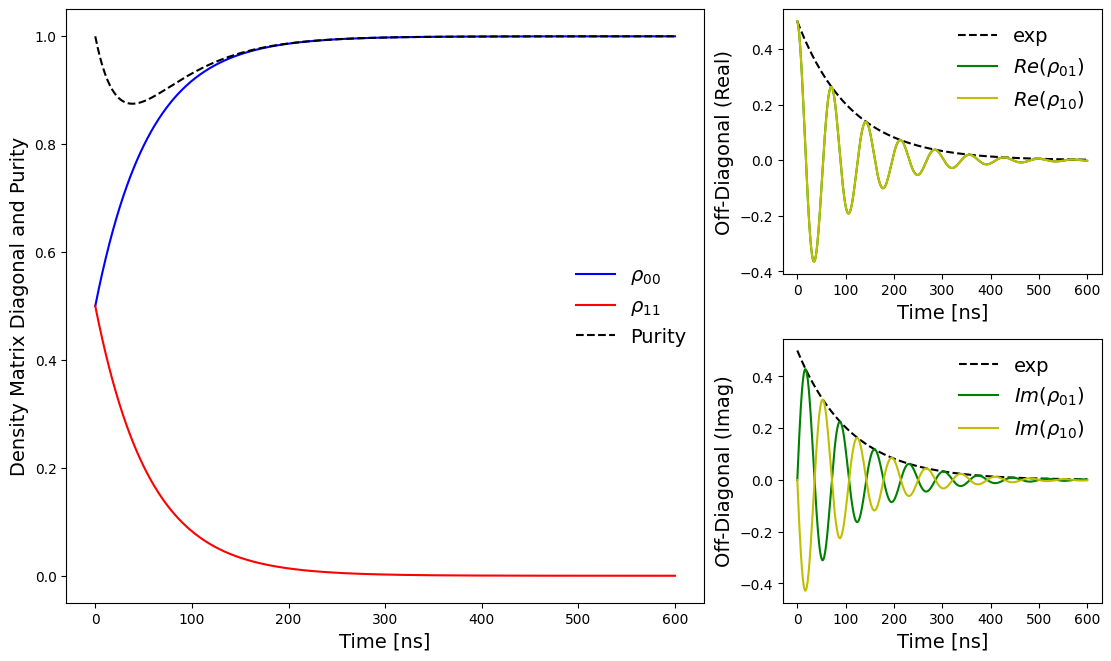

At $0.2*\gamma$

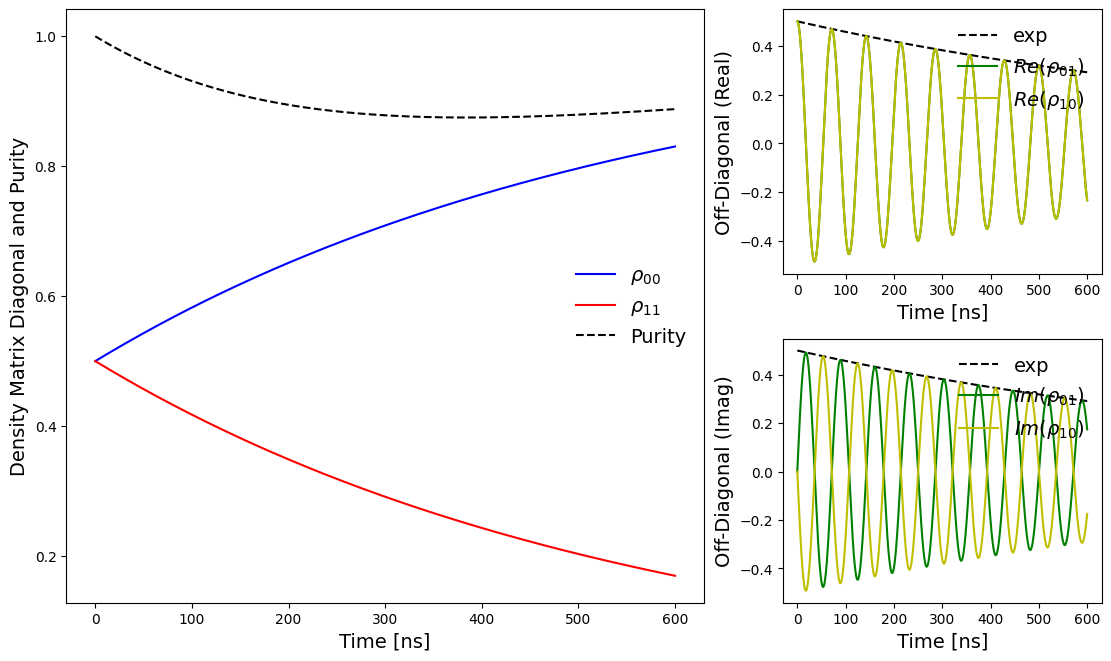

If the decay rate is increased to $2*\gamma$ the decay to the ground state is exponentially more rapid, and similarily if the decay rate is decreased to $0.2*\gamma$, the decay is exponentially slower. We see this if we scale our time up to see how long it takes for $0.2*\gamma$ to deacy fully.
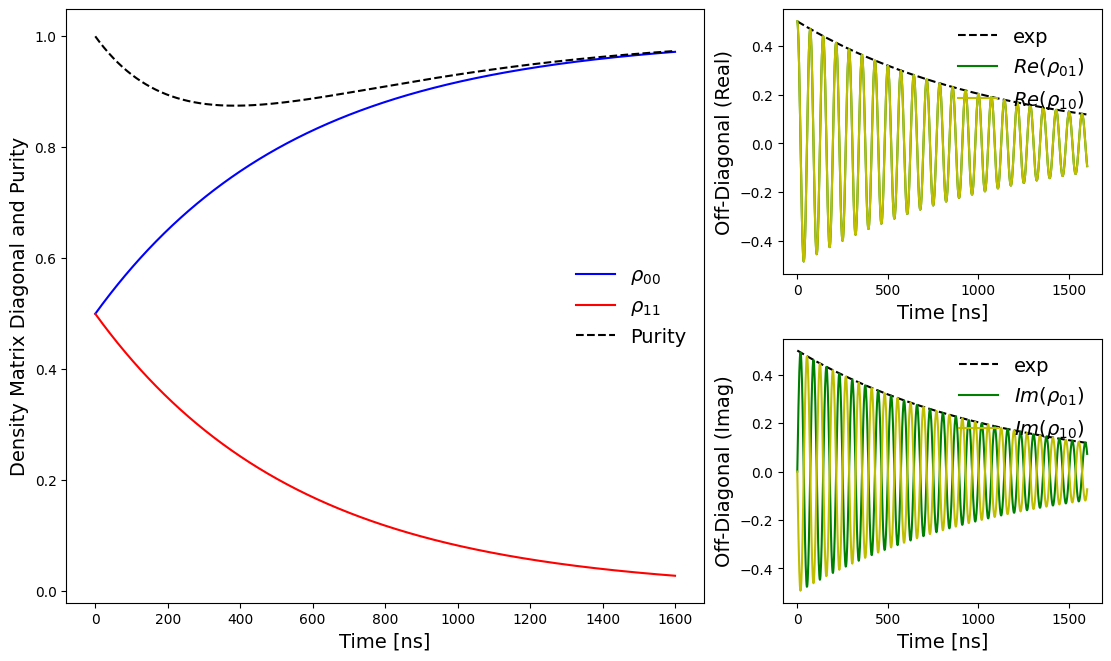

The off- diagonal entries tend to zero. THis measn that as time progresses outr state becomes a statistical mixture of |0> and |1> states, which is simply a classical mixture of states with no quantum mechanical behaviour. These are graphed alongside each of the graph rates. 

###
<b>Consider a qubit coupled to an external noisy environment, such that it undergoes dephasing. What is
the form of the Lindblad equation in this case? How do the diagonal and off-diagonal elements of the
density matrix evolve over time. You should use the decay rate from the previous questions as your
dephasing rate.</b>


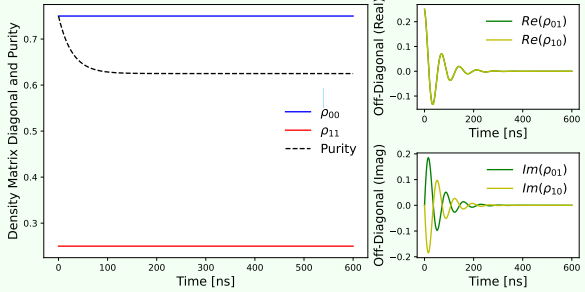

The off- diagonal entries tend to zero. This measn that as time progresses outr state becomes a statistical mixture of |0> and |1> states, which is simply a classical mixture of states with no quantum mechanical behaviour. 

In [9]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy.constants import physical_constants
from scipy.integrate import solve_ivp

In [10]:
#Constants
energy_zero      = -0.0005*physical_constants['Bohr magneton'][0]
energy_one       = +0.0005*physical_constants['Bohr magneton'][0]
tunnel_energy    = 1.0
relaxation_gamma = 1/(111e-9)

#Basis States
basis_states = [np.array([[1],[0]]), np.array([[0],[1]])]

#Hamiltonian of electron spin in magnetic field
hamiltonian = np.array([[energy_zero, 0],[0,energy_one]])

# Create density matrix with initial conditions
# - Create as vector for using solve_ivp
density_matrix_init  = np.array([1/2, 1/2, 1/2, 1/2]).astype(complex)

In [11]:
# Helper Functions
def dagger(state):
    return np.transpose(np.conj(state))

def commutator(matA, matB):
    return (np.matmul(matA, matB) - np.matmul(matB, matA))

def anticommutator(matA, matB):
    return (np.matmul(matA, matB) + np.matmul(matB, matA))

def dissipator(gamma, density_matrix):
    rho     = density_matrix.reshape((2,2))     # Reshaping the density operator into a matrix for multiplication
    jump_op = basis_states[0]@basis_states[1].T # Which jump operator is this?
    dissipation_term  = gamma*(jump_op@rho@dagger(jump_op))
    dissipation_term -= gamma*(0.5)*anticommutator(dagger(jump_op)@jump_op, rho)
    return dissipation_term

def density_dot(time, density_matrix):
    # Von Neumann Contribution
    current_density_dot = (-1j/const.hbar)*commutator(hamiltonian, density_matrix.reshape((2,2)))
    # Dissispator Contribution
    current_density_dot += dissipator(relaxation_gamma, density_matrix)
    return (current_density_dot.reshape((1,-1))) #Reshape into a vector for the solve_ivp() function

In [12]:
# Solving the Lindblad Equation

# Time Parameters
T_MIN = 0
T_MAX = 600e-9
# Solve the initial value problem
sol = solve_ivp(density_dot, [T_MIN, T_MAX], density_matrix_init.reshape((4,)), max_step=T_MAX/1000)

In [13]:
# Extract Populations
density_matrix_00 = sol.y[0]
density_matrix_01 = sol.y[1]
density_matrix_10 = sol.y[2]
density_matrix_11 = sol.y[3]

# Calculate Purity at each time step
purity = []
for index in range(len(sol.t)):
    current_density_matrix = np.array([[sol.y[0,index],sol.y[1,index]],[sol.y[2,index],sol.y[3,index]]])
    current_purity = np.trace(current_density_matrix@current_density_matrix)
    purity.append(current_purity)

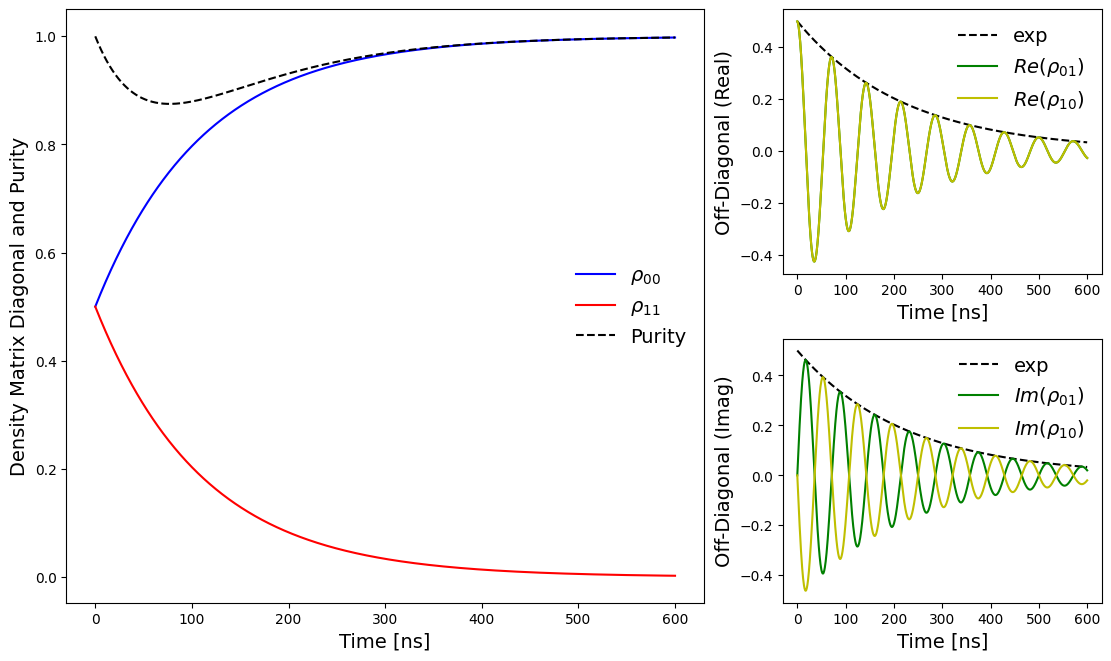

In [14]:
# Plotting

fig = plt.figure(constrained_layout=True, figsize=(11,6.5))
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
axs['Left'].plot(sol.t*1e9, np.real(density_matrix_00), label=r"$\rho_{00}$", color='b')
axs['Left'].plot(sol.t*1e9, np.real(density_matrix_11), label=r"$\rho_{11}$", color='r')
#axs['Left'].plot(sol.t*1e9, np.exp(-relaxation_gamma*sol.t)*0.5 + 0.5, label=r"exp", color='y', ls='--')
axs['Left'].plot(sol.t*1e9, purity, label=r"Purity", color='k', ls='--')

axs['TopRight'].plot(sol.t*1e9, np.exp(-relaxation_gamma/2*sol.t)*0.5, label=r"exp", color='k', ls='--')
axs['TopRight'].plot(sol.t*1e9, density_matrix_01.real, label=r"$Re(\rho_{01})$", color='g')
axs['TopRight'].plot(sol.t*1e9, density_matrix_10.real, label=r"$Re(\rho_{10})$", color='y')

axs['BottomRight'].plot(sol.t*1e9, np.exp(-relaxation_gamma/2*sol.t)*0.5, label=r"exp", color='k', ls='--')
axs['BottomRight'].plot(sol.t*1e9, density_matrix_01.imag, label=r"$Im(\rho_{01})$", color='g')
axs['BottomRight'].plot(sol.t*1e9, density_matrix_10.imag, label=r"$Im(\rho_{10})$", color='y')

# Legend Placement
axs['Left'].legend(fontsize=14, frameon=False, loc='center right')#, bbox_to_anchor=(0.7,0.65))
axs['Left'].set_xlabel('Time [ns]', fontsize=14)
axs['Left'].set_ylabel('Density Matrix Diagonal and Purity', fontsize=14)

axs['TopRight'].legend(fontsize=14, frameon=False, loc='upper right')#, bbox_to_anchor=(0.7,0.65))
axs['TopRight'].set_xlabel('Time [ns]', fontsize=14)
axs['TopRight'].set_ylabel('Off-Diagonal (Real)', fontsize=14)

axs['BottomRight'].legend(fontsize=14, frameon=False, loc='upper right')#, bbox_to_anchor=(0.7,0.65))
axs['BottomRight'].set_xlabel('Time [ns]', fontsize=14)
axs['BottomRight'].set_ylabel('Off-Diagonal (Imag)', fontsize=14)


fig.patch.set_alpha(0.0)
axs['Left'].patch.set_alpha(1.0)
axs['TopRight'].patch.set_alpha(1.0)
axs['BottomRight'].patch.set_alpha(1.0)
#plt.savefig("lindblad_plusinitial_decay.pdf", dpi=300, bbox_inches = "tight")
plt.show()